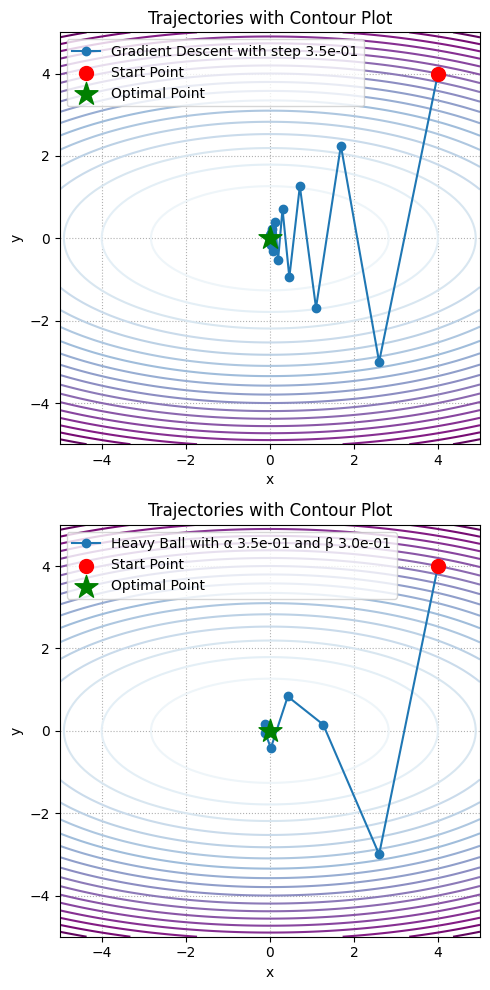

In [2]:
from jax import value_and_grad

import numpy as np
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController
import jax.numpy as jnp
from jax import grad

# Quadratic function setup
# Corrected Quadratic function setup
A = jnp.array([[1., 0], [0, 5.]])  # Using jax.numpy for compatibility
quadratic_function = lambda x: 0.5 * jnp.dot(x, jnp.dot(A, x))  # Correct use of jnp.dot for matrix multiplication
grad_quadratic_function = grad(quadratic_function)  # Correct gradient computation

alpha = 0.35
beta=0.3
num_steps = 30

# Plot contours function
def plot_contours(function, x_range, y_range, resolution=100):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)  # Initialize Z with the correct shape
    
    # Compute the function value for each point on the grid
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = function(np.array([X[i, j], Y[i, j]]))
    
    plt.contour(X, Y, Z, levels=20, cmap="BuPu")


# Gradient Descent Method
def gradient_descent(grad_func, start_point, learning_rate=0.1, num_steps=50):
    trajectory = [start_point]
    x = start_point
    for _ in range(num_steps):
        grad = grad_func(x)
        x = x - learning_rate * grad
        trajectory.append(x)
    return np.array(trajectory)

# Heavy Ball
def heavy_ball(grad_func, start_point, learning_rate=0.1, beta=beta, num_steps=50):
    trajectory = [start_point]
    x = start_point
    v = np.array([0, 0])
    for _ in range(num_steps):
        grad = grad_func(x)
        v = grad + beta*v
        x = x - learning_rate * v
        trajectory.append(x)
    return np.array(trajectory)

# Setup
start_point = jnp.array([4.0, 4.0])

# Solve trajectories
trajectory_gd = gradient_descent(grad_quadratic_function, start_point, alpha, num_steps)
trajectory_hb = heavy_ball(grad_quadratic_function, start_point, alpha, num_steps=num_steps)


# Plotting
plt.figure(figsize=(5, 10))

# Left subplot for contour and trajectories
plt.subplot(2, 1, 1)
plot_contours(quadratic_function, x_range=(-5, 5), y_range=(-5, 5))
plt.plot(trajectory_gd[:, 0], trajectory_gd[:, 1], 'o-',  label=f'Gradient Descent with step {alpha:.1e}')
plt.scatter(*start_point, color='red', marker='o', s=100, zorder=5, label='Start Point')
plt.scatter(0, 0, color='green', marker='*', s=300, zorder=5, label='Optimal Point')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories with Contour Plot')
plt.legend()
plt.grid(linestyle=":")

# Right subplot for semilogy convergence
plt.subplot(2, 1, 2)
plot_contours(quadratic_function, x_range=(-5, 5), y_range=(-5, 5))
plt.plot(trajectory_hb[:, 0], trajectory_hb[:, 1], 'o-',  label=f'Heavy Ball with α {alpha:.1e} and β {beta:.1e}')
plt.scatter(*start_point, color='red', marker='o', s=100, zorder=5, label='Start Point')
plt.scatter(0, 0, color='green', marker='*', s=300, zorder=5, label='Optimal Point')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Trajectories with Contour Plot')
plt.legend()
plt.grid(linestyle=":")

plt.tight_layout()
plt.savefig("GD_HB.pdf")
plt.show()

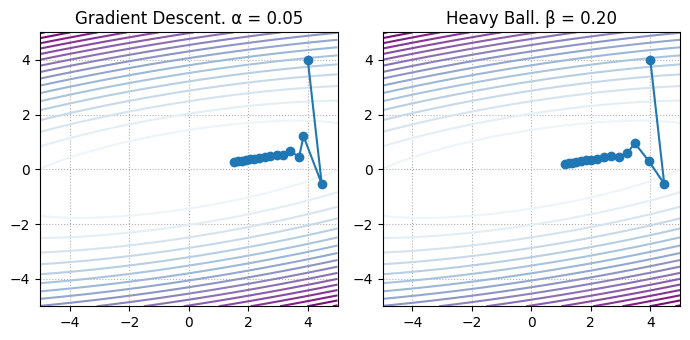

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad

mu = 1
L = 20
beta = 0.2

theta = np.radians(10)
Q = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Lambda = np.diag([mu, L])
A = np.dot(Q, np.dot(Lambda, Q.T))
quadratic_function = lambda x: 0.5 * jnp.dot(x, jnp.dot(A, x))
grad_quadratic_function = grad(quadratic_function)

# Plot contours function
def plot_contours(ax, function, x_range, y_range, resolution=200):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = function(np.array([X[i, j], Y[i, j]]))
    
    ax.contour(X, Y, Z, levels=20, cmap="BuPu")

# Gradient Descent with Exact Line Search
def gradient_descent(grad_func, x, learning_rate = 1/L, num_steps=50):
    trajectory = [x]
    for _ in range(num_steps):
        gradient = grad_func(x)
        x = x - learning_rate * gradient
        trajectory.append(x)
    return np.array(trajectory)

# Heavy Ball
def heavy_ball(grad_func, start_point, learning_rate=0.1, beta=0.9, num_steps=50):
    trajectory = [start_point]
    x = start_point
    v = np.array([0, 0])
    for _ in range(num_steps):
        grad = grad_func(x)
        v = grad + beta*v
        x = x - learning_rate * v
        trajectory.append(x)
    return np.array(trajectory)

# Setup start point and b vector for CG
start_point = jnp.array([4.0, 4.0])
b = jnp.dot(A, jnp.zeros(2))  # Arbitrary choice for illustration

# Solve trajectories
trajectory_gd_exact = gradient_descent(grad_quadratic_function, start_point, learning_rate=7e-2, num_steps=15)
trajectory_cg = heavy_ball(grad_quadratic_function, start_point, learning_rate=7e-2, beta=beta, num_steps=15)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(7, 3.5))

# Gradient Descent with Exact Line Search Plot
plot_contours(axs[0], quadratic_function, x_range=(-5, 5), y_range=(-5, 5))
axs[0].plot(trajectory_gd_exact[:, 0], trajectory_gd_exact[:, 1], 'o-', label='Steepest Descent')
axs[0].set_title(f'Gradient Descent. α = {1/L:.2f}')

# Conjugate Gradient Plot
plot_contours(axs[1], quadratic_function, x_range=(-5, 5), y_range=(-5, 5))
axs[1].plot(trajectory_cg[:, 0], trajectory_cg[:, 1], 'o-', label='Heavy Ball ')
axs[1].set_title(f'Heavy Ball. β = {beta:.2f}')

for ax in axs:
    # ax.legend()
    ax.grid(linestyle=":")

plt.tight_layout()
plt.savefig(f"GD_vs_HB_hor_{L}.pdf")
plt.show()


# Acceleration

0.14589803375031546
[ 1.7462978 16.78138  ]
[  5.638241 -11.590431]
[0.7643439 7.345113 ]
[ 1.6452167 -3.3820438]
[0.18586016 1.7860639 ]


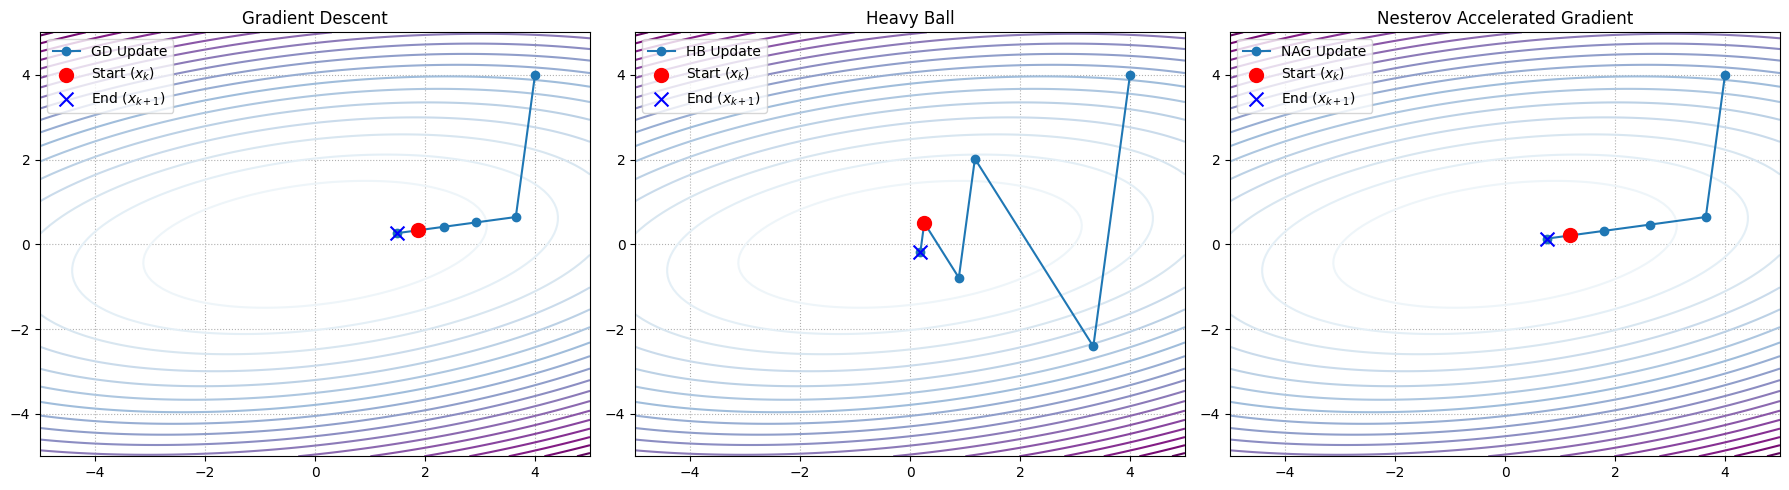

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad

mu = 1
L = 5
# Quadratic function setup
# Define A, b, and c for both functions
theta = np.radians(10)
Q = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Lambda = np.diag([mu, L])
A = np.dot(Q, np.dot(Lambda, Q.T))
quadratic_function = lambda x: 0.5 * jnp.dot(x, jnp.dot(A, x))
grad_quadratic_function = grad(quadratic_function)


num_steps = 1  # Adjusted to only plot one iteration

# Plot contours function
def plot_contours(ax, function, x_range, y_range, resolution=100):
    x = np.linspace(x_range[0], x_range[1], resolution)
    y = np.linspace(y_range[0], y_range[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Z[i, j] = function(np.array([X[i, j], Y[i, j]]))
    
    ax.contour(X, Y, Z, levels=20, cmap="BuPu")

# Gradient Descent Method
def gradient_descent(grad_func, start_point, learning_rate=0.1, num_steps=50):
    trajectory = [start_point]
    x = start_point
    for _ in range(num_steps):
        grad = grad_func(x)
        x = x - learning_rate * grad
        trajectory.append(x)
    return np.array(trajectory)

# Heavy Ball
def heavy_ball(grad_func, start_point, learning_rate=0.1, beta=beta, num_steps=50):
    trajectory = [start_point]
    x = start_point
    v = np.array([0, 0])
    v_traj = [v]
    for _ in range(num_steps):
        grad = grad_func(x)
        v = grad + beta*v
        x = x - learning_rate * v
        trajectory.append(x)
        v_traj.append(v)
        print(v)
    return np.array(trajectory), v_traj

# Nesterov Accelerated Gradient (Setup)
def nesterov_accelerated_gradient(grad_func, start_point, learning_rate=0.1, beta=0.9, num_steps=50):
    trajectory = [start_point]
    x = start_point
    v = np.array([0, 0])
    y_traj = [v]
    for _ in range(num_steps):
        v = beta * v - learning_rate * grad_func(x + beta * v)
        x = x + v
        trajectory.append(x)
        y_traj.append(v)
    return np.array(trajectory), y_traj

# Setup start point
start_point = jnp.array([4.0, 4.0])

# Solve trajectories for each method
alpha = 1/L
trajectory_gd = gradient_descent(grad_quadratic_function, start_point, alpha, 5)  # Adjusted for two points
alpha = 4/(np.sqrt(L) + np.sqrt(mu))**2
beta = ((np.sqrt(L) - np.sqrt(mu))/(np.sqrt(L) + np.sqrt(mu)))**2
print(beta)
trajectory_hb, v_traj = heavy_ball(grad_quadratic_function, start_point, alpha, beta, 5)  # Adjusted for two points

alpha = 1/L
beta = (np.sqrt(L) - np.sqrt(mu))/(np.sqrt(L) + np.sqrt(mu))
trajectory_nag, y_traj = nesterov_accelerated_gradient(grad_quadratic_function, start_point, alpha, beta, 5)  # Adjusted for two points

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # Adjusted for a single row of three subplots

# Gradient Descent Plot
plot_contours(axs[0], quadratic_function, x_range=(-5, 5), y_range=(-5, 5))
axs[0].plot(trajectory_gd[:, 0], trajectory_gd[:, 1], 'o-', label='GD Update')
axs[0].scatter(*trajectory_gd[-2], color='red', marker='o', s=100, zorder=5, label='Start ($x_k$)')
axs[0].scatter(*trajectory_gd[-1], color='blue', marker='x', s=100, zorder=5, label='End ($x_{k+1}$)')
axs[0].set_title('Gradient Descent')

# Heavy Ball Plot
plot_contours(axs[1], quadratic_function, x_range=(-5, 5), y_range=(-5, 5))
axs[1].plot(trajectory_hb[:, 0], trajectory_hb[:, 1], 'o-', label='HB Update')
axs[1].scatter(*trajectory_hb[-2], color='red', marker='o', s=100, zorder=5, label='Start ($x_k$)')
axs[1].scatter(*trajectory_hb[-1], color='blue', marker='x', s=100, zorder=5, label='End ($x_{k+1}$)')
axs[1].set_title('Heavy Ball')

# Nesterov Accelerated Gradient Plot
plot_contours(axs[2], quadratic_function, x_range=(-5, 5), y_range=(-5, 5))
axs[2].plot(trajectory_nag[:, 0], trajectory_nag[:, 1], 'o-', label='NAG Update')
axs[2].scatter(*trajectory_nag[-2], color='red', marker='o', s=100, zorder=5, label='Start ($x_k$)')
axs[2].scatter(*trajectory_nag[-1], color='blue', marker='x', s=100, zorder=5, label='End ($x_{k+1}$)')
axs[2].set_title('Nesterov Accelerated Gradient')

for ax in axs:
    ax.legend()
    ax.grid(linestyle=":")

plt.tight_layout()
plt.savefig("AGD.pdf")
plt.show()
